# CA684 Machine Learning Assignment Spring 2022

As part of this assignment, we are predicting possible matches between Zalando and About You products. We are trying to maximize the overall F1 score.

Methodology: The approach followed for this assignment is basically Divide and Conquer. The task of getting exact product matches between the 2 e-commerce websites was divided into two sub-tasks:

1. Binary Classification (using CNN-LSTM Model)

1a. In the first stage, a Binary Classifier  was implemented to classify whether the two products (of "Zalando" and "AboutYOU") were possible match or not.

1b. For the classification one product of "Zalando" was matched with a series of products of "About You". Only those products were considered that were classified as possible matches (Binary 1) by the model .

2. Ranking Mechanism

2a. In the second stage, the concatenated result of Title and Colour of "Zalondo" products were vectorized. Similarly, the concatenated result of Title and Colour of "AboutYOU"  products (that were classified as possible matches by Binary CClassifier in step 1b) were vectorized. Sentence vectorization was implemented using a pretrained multilingual Bert Model(trained on German text data). 

2b. After vectorization, Cosine Similarity was performed between the vector of "Zalando" products and the vector of "AboutYou" products to determine the product of "About You" which has very high semantic similarity to "Zalando" product.

## Importing Required Libraries

In [ ]:
# libraries
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import urllib
import urllib.request
from random import choices
from itertools import chain
import gc,cv2,math
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from keras.models import Sequential
from keras.layers import Input, LSTM, Bidirectional, Dense
from keras.layers import Embedding, Flatten
from keras.layers import MaxPooling1D, Dropout, Activation, Conv1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import warnings
from tensorflow.keras.applications import EfficientNetB4,ResNet101,EfficientNetB5
from sklearn.metrics.pairwise import cosine_similarity
from keras.preprocessing.sequence import pad_sequences
from keras.models import model_from_json
from keras import backend as K
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import re
!pip3 install pickle5
import pickle5 as pickle
!pip3 install sentence_transformers
from sentence_transformers import SentenceTransformer,util
pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
print(tf.__version__)

# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)

# Pandas config
pd.options.mode.chained_assignment = None  # default='warn'

     |████████████████████████████████| 256 kB 8.9 MB/s 
     |████████████████████████████████| 79 kB 4.8 MB/s 
     |████████████████████████████████| 3.8 MB 16.3 MB/s 
     |████████████████████████████████| 1.2 MB 40.1 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 6.5 MB 58.9 MB/s 
     |████████████████████████████████| 596 kB 51.9 MB/s 
     |████████████████████████████████| 895 kB 62.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=6d89ca00fcfded7e8fa624eb89a57f10464b8fd1d0a5f3ee6ffd25f091ccf597
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
2.8.0


In [ ]:
# set random seed
np.random.seed(seed=42)

## Mounting Google Drive where the required datasets and files are present.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Listing the files present in the repository.

In [ ]:
!ls '/content/drive/MyDrive/ML_Assignment/'{offers,matches}_{training,test}.parquet

ls: cannot access '/content/drive/MyDrive/ML_Assignment/matches_test.parquet': No such file or directory
/content/drive/MyDrive/ML_Assignment/matches_training.parquet
/content/drive/MyDrive/ML_Assignment/offers_test.parquet
/content/drive/MyDrive/ML_Assignment/offers_training.parquet


## Exploratory Data Analysis

The following is just some Pandas preprocessing and Matplotlib visualizations 

### Training and Test Datasets containing Zalando and AboutYOU Products

In [ ]:
# Loading offers training file in a dataframe
offers_training_df = pd.read_parquet('/content/drive/MyDrive/ML_Assignment/offers_training.parquet')

In [ ]:
offers_training_df.head(10)

,offer_id,shop,lang,brand,color,title,description,price,url,image_urls
0,d8e0dba8-98e8-48db-9850-dd30cff374e0,aboutyou,de,PIECES,hellblau | Blau,Kleid,"{""Material"": [""Baumwolle""], ""\u00c4rmell\u00e4nge"": [""\u00c4rmellos""], ""Tr\u00e4gerart"": [""Normaler Tr\u00e4ger""], ""Ausschnitt"": [""Rundhals-Ausschnitt""], ""L\u00e4nge"": [""Kurz/Mini""], ""Marke"": [""PIECES""], ""Passform"": [""Figurbetonte Passform""], ""Zielgruppe"": [""Frauen""], ""Quick Filter Style Group"": [""Trend""], ""Suchfarbe"": [""Blau""], ""Gr\u00f6\u00dfenlauf"": [""Damen - Intern.""], ""Detailfarbe"": [""hellblau""], ""Ordersaison"": [""FS 21""], ""Muster"": [""Unifarben""], ""Business"": [""Freizeit""], ""Design"": [""Rippstrick"", ""Eingefasster Ausschnitt""], ""Extras"": [""Weicher Griff"", ""Ton-in-Ton-N\u00e4hte""], ""Ursprungsland"": [""T\u00fcrkei""], ""Saison"": [""Fr\u00fchjahr / Sommer""], ""Geschlecht"": [""Frauen""], ""Size Chart"": [""female tops""], ""Produktart"": [""Kleid""], ""Gr\u00f6\u00dfe"": [""def_female_konf""], ""Sondergr\u00f6\u00dfen f\u00fcr Kategoriezuordnung"": [""Kleine Cups"", ""Mittlere Cups"", ""Gro\u00dfe Cups""], ""styleCluster"": [""6""], ""Display Colors"": [""hellblau""], ""Style group"": [""trend""], ""Brand logo"": [""PIECES""], ""Name"": [""Kleid""], ""Description"": [""- Rundhalsausschnitt\n- Dehnbares geripptes Material\n- Einfarbig\n- K\u00f6rperbetonte Passform""], ""Produkt Beschreibung"": ""- Rundhalsausschnitt\n- Dehnbares geripptes Material\n- Einfarbig\n- K\u00f6rperbetonte Passform"", ""Materialzusammensetzung"": ""Material 95 Baumwolle % 5 Elasthan %"", ""Bulletpoints"": ""Rundhalsausschnitt Dehnbares geripptes Material Einfarbig""}",24.990000,https://www.aboutyou.de/p/pieces/kleid-6732409,"[https://cdn.aboutstatic.com/file/images/06728ca28bd977a249d2888ec0d58bef.jpg?width=600&height=800&quality=0.90, https://cdn.aboutstatic.com/file/images/26dfad2c63c77744f070801ce987eb8e.jpg?width=600&height=800&quality=0.90, https://cdn.aboutstatic.com/file/images/071ed00f251eb6ec15060c2b52b86602.jpg?width=600&height=800&quality=0.90, https://cdn.aboutstatic.com/file/images/6ef1c268348d2a489a1df8296d6451fb.jpg?width=600&height=800&quality=0.90, https://cdn.aboutstatic.com/file/images/a55f03c0a629c2e03dae5f248823e616.jpg?width=600&height=800&quality=0.90, https://cdn.aboutstatic.com/file/images/d416c092959786e96390e6473d985579.jpg?width=600&height=800&quality=0.90]"
1,c0a743f8-68cf-44dc-80cf-b5edbe70ecb7,aboutyou,de,LASCANA,schwarz | mischfarben | Schwarz,Bikinihose,"{""Leibh\u00f6he"": [""Super Low Waist""], ""Marke"": [""LASCANA""], ""Quick Filter Style Group"": [""Klassisch""], ""Suchfarbe"": [""Schwarz""], ""Gr\u00f6\u00dfenlauf"": [""Damen - Konf. D""], ""Detailfarbe"": [""schwarz"", ""mischfarben""], ""Muster"": [""Gebl\u00fcmt/floral""], ""Design"": [""Abgesteppter Saum/Kante""], ""Extras"": [""Label Plate"", ""Applikationen""], ""Vendorsizerun-Label"": [""Deutsche Konfektion""], ""Gr\u00f6\u00dfe"": [""def_female_int""], ""Sondergr\u00f6\u00dfen f\u00fcr Kategoriezuordnung"": [""Gro\u00dfe Gr\u00f6\u00dfe"", ""Mittlere Cups"", ""Kleine Cups"", ""Gro\u00dfe Cups""], ""Geschlecht"": [""Frauen""], ""Produktart"": [""Bikinihose""], ""Supplier"": [""Otto""], ""Neu"": [""new_aoat""], ""Material Nachhaltigkeit"": [""Recyceltes Polyamid""], ""Nachhaltigkeit"": [""Eco-Friendly material""], ""Display Colors"": [""schwarz""], ""Style group"": [""modern""], ""Brand logo"": [""LASCANA""], ""Sustainable"": true, ""Sponsor badge"": [""sponsorBadge""], ""Sponsored type"": [""sponsoredType""], ""Name"": [""Bikinihose""], ""Description"": [""<table class=\""tmpArticleDetailTable\""><caption><b>Produktdetails</b></caption><tbody><tr><td class=\""left\""><div><span>Pflegehinweise</span></div></td><td>Handw&auml;sche</td></tr></tbody></table>""], ""Produkt Beschreibung"": ""<table class=\""tmpArticleDetailTable\""><caption><b>Produktdetails</b></caption><tbody><tr><td class=\""left\""><div><span>Pflegehinweise</span></div>

In [ ]:
offers_training_df.shape

(102884, 10)

In [ ]:
f'Number of products in training: {len(offers_training_df):,}'

'Number of products in training: 102,884'

In [ ]:
list(offers_training_df.columns)

['offer_id',
 'shop',
 'lang',
 'brand',
 'color',
 'title',
 'description',
 'price',
 'url',
 'image_urls']

In [ ]:
offers_training_df['lang'].unique()

array(['de'], dtype=object)

In [ ]:
#Verifying number of products in each shop in training dataset
pd.value_counts(offers_training_df['shop'], sort=True, ascending=False)

aboutyou    61980
zalando     40904
Name: shop, dtype: int64

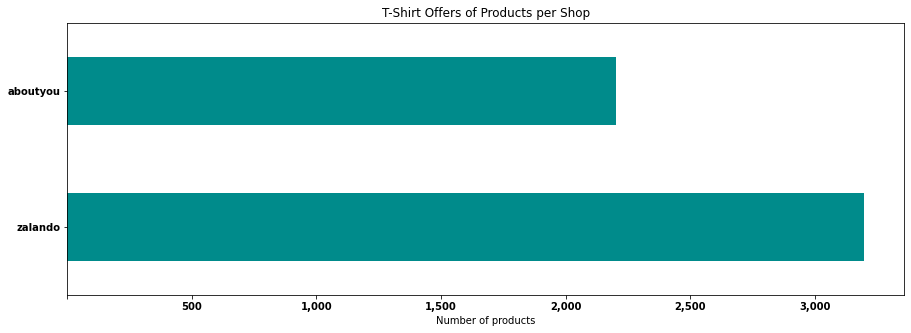

In [ ]:
# Visualizing quantity of a specific product in both websites (Zalando and AboutYou)

figure, ax = plt.subplots(figsize=(15, 5))
pd.value_counts(
    offers_training_df[
        offers_training_df['title'].str.lower().str.contains("t-shirt", na=False)
    ]['shop'], 
    sort=True, ascending=False).plot.barh(color='darkcyan')
plt.title('T-Shirt Offers of Products per Shop')
xlabels = [f'{x:,}' for x in range(0, 3500, 500)]
plt.xticks(range(0, 3500, 500), xlabels)
plt.xlabel('Number of products')
plt.setp(ax.get_xticklabels()[0], visible=False)
plt.show()

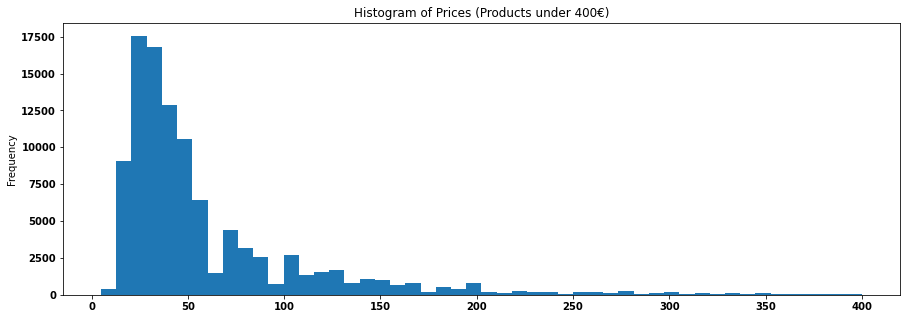

In [ ]:
# Visualizing Price Distribution for products which are less than 400 Euros
figure, ax = plt.subplots(figsize=(15, 5))
plt.title('Histogram of Prices (Products under 400€)')
offers_training_df[
    offers_training_df['price'] < 400
]['price'].plot.hist(bins=50)
plt.show()

In [ ]:
brands_training = offers_training_df['brand'].unique()

In [ ]:
brands_training[:10]

array(['PIECES', 'LASCANA', 'MAMALICIOUS', 'rosemunde', 'Guess',
       'ELLESSE', 'Ellesse', 'Free People', 'BULLBOXER', 'Selected'],
      dtype=object)

In [ ]:
f'Number of unique brands in training: {len(brands_training):,}'

'Number of unique brands in training: 145'

In [ ]:
#Loading offers test file in a dataframe
offers_test_df = pd.read_parquet('/content/drive/MyDrive/ML_Assignment/offers_test.parquet')

In [ ]:
offers_test_df.head(10)

,offer_id,shop,lang,brand,color,title,description,price,url,image_urls
0,67069c3c-46a7-45ea-ae0f-1cac2571ae68,aboutyou,de,DKNY,beige | Beige,Schal,"{""Marke"": [""DKNY""], ""Gr\u00f6\u00dfenlauf"": [""Unisex - Onesize (Onesize, Onesize, Einheitsgr\u00f6\u00dfe, 1)""], ""Detailfarbe"": [""beige""], ""Suchfarbe"": [""Beige""], ""Assortment Type"": [""Second Hand""], ""Zustand"": [""Mit Sch\u00f6nheitsfehlern""], ""Kategorieattribut"": [""Schal""], ""Versand durch"": [""Carou""], ""Substilgruppe"": [""Regular Second Hand""], ""Zustand \u2013 Mit Sch\u00f6nheitsfehlern"": [""Der Artikel wurde getragen und hat sichtbare Gebrauchsspuren.""], ""Second Hand Type"": [""Regular Second Hand""], ""Gebraucht"": true, ""Ausrichtung Marke"": [""Premium""], ""Geschlecht"": [""Frauen""], ""Quick Filter Style Group"": [""Premium""], ""Gr\u00f6\u00dfe"": [""Unisex - Onesize (Onesize, Onesize, Einheitsgr\u00f6\u00dfe, 1)""], ""Display Colors"": [""beige""], ""Style group"": [""premium""], ""Brand logo"": [""DKNY""], ""Name"": [""Schal""], ""Description"": [""""]}",49.990000,https://www.aboutyou.de/p/dkny/schal-7221536,"[https://cdn.aboutstatic.com/file/images/d84322132c044ee5c283f954a1be1269.JPG?width=600&height=800&quality=0.90, https://cdn.aboutstatic.com/file/images/254abcf31f149239d0ffac5cc7bf1d0b.JPG?width=600&height=800&quality=0.90, https://cdn.aboutstatic.com/file/images/98034e4993801e489917f6bdaee1d3d5.JPG?width=600&height=800&quality=0.90, https://cdn.aboutstatic.com/file/images/8064073408854d801ef64433e33a47e8.JPG?width=600&height=800&quality=0.90]"
1,c065bcd3-0669-4061-b1ce-fd6467f81b91,aboutyou,de,MICHAEL Michael Kors,schwarz | Mischfarben,Plisseerock,"{""Marke"": [""MICHAEL Michael Kors""], ""Gr\u00f6\u00dfenlauf"": [""Damen - Konf. D""], ""Suchfarbe"": [""Mischfarben""], ""Assortment Type"": [""Second Hand""], ""Zustand"": [""Wie neu""], ""Kategorieattribut"": [""Faltenr\u00f6cke""], ""Versand durch"": [""Carou""], ""Detailfarbe"": [""schwarz""], ""Ausrichtung Marke"": [""Premium""], ""Substilgruppe"": [""Regular Second Hand""], ""Zustand \u2013 Wie neu"": [""Der Artikel wurde nicht getragen, sondern h\u00f6chstens anprobiert. Manche dieser Artikel tragen noch ihr Etikett.""], ""Vendorsizerun-Label"": [""Deutsche Konfektion""], ""Second Hand Type"": [""Regular Second Hand""], ""Gebraucht"": true, ""Geschlecht"": [""Frauen""], ""Size Chart"": [""female bottoms""], ""Size Advisor"": true, ""Gr\u00f6\u00dfe"": [""def_female_int""], ""Sondergr\u00f6\u00dfen f\u00fcr Kategoriezuordnung"": [""Kleine Cups""], ""Brand logo"": [""MICHAEL Michael Kors""], ""Name"": [""Plisseerock""], ""Description"": [""""]}",79.980000,https://www.aboutyou.de/p/michael-michael-kors/plisseerock-7213763,"[https://cdn.aboutstatic.com/file/images/687cdafa2c8d31bd1b539fc3b12ec38d.JPG?width=600&height=800&quality=0.90, https://cdn.aboutstatic.com/file/images/1e9fbbf39971e5dc414afdfb59c6b26d.JPG?width=600&height=800&quality=0.90, https://cdn.aboutstatic.com/file/images/7544e2390336b118bee8c73dd65934d7.JPG?width=600&height=800&quality=0.90, https://cdn.aboutstatic.com/file/images/501506459062ba15bb99f8b1d9046fd1.JPG?width=600&height=800&quality=0.90]"
2,7dfb8ecf-ba37-42dc-9287-78bac2b0e192,aboutyou,de,MICHAEL Michael Kors,hellbraun | mokka | Braun,Tasche,"{""Zielgruppe"": [""Female""], ""Gr\u00f6\u00dfe (Volumen)"": [""Klein (< 25 l)""], ""Gurt-/Henkell\u00e4nge"": [""Kurzer Trageriemen / Henkel""], ""Marke"": [""MICHAEL Michael Kors""], ""Material"": [""Lederimitat""], ""Verschlussart"": [""Druckknopf""], ""Ausrichtung Marke"": [""Premium""], ""Suchfarbe"": [""Braun""], ""Gr\u00f6\u00dfenlauf"": [""Unisex - Onesize (Onesize, Onesize, Einheitsgr\u00f6\u00dfe, 1)""], ""Detailfarbe"": [""hellbraun"", ""mokka""], ""Ordersaison"": [""HW 21""], ""Muster"": [""Logoprint""], ""Business"": [""Freizeit""], ""Design"": [""Ger\u00e4umiges Hauptfach"", ""Rei\u00dfverschluss"", ""Rei\u00dfverschlussfach innen""], ""Extras"": [""Metall\u00f6sen"", ""Robuster Stoff"", ""All-Over-M

In [ ]:
#Verifying number of products in each shop in test dataset
pd.value_counts(offers_test_df['shop'], sort=True, ascending=False)

aboutyou    70105
zalando     36636
Name: shop, dtype: int64

In [ ]:
offers_test_df.shape

(106741, 10)

In [ ]:
# Obtaining the test dataframe in a csv file for further model training
offers_test_df.to_csv('/content/drive/MyDrive/ML_Assignment/offers_test.csv')

In [ ]:
f'Number of products in test dataset: {len(offers_test_df):,}'

'Number of products in test dataset: 106,741'

In [ ]:
brands_test = offers_test_df['brand'].unique()

In [ ]:
f'Number of unique brands in test dataset: {len(brands_test):,}'

'Number of unique brands in test dataset: 164'

### Checking if there are intersecting brands in 'training' and 'test' Brand Dataframe

In [ ]:
# Intersection between brands in training and test
f'Number of brands in train and test: {sum(np.in1d(brands_training, brands_test, assume_unique=True)):,}'

'Number of brands in train and test: 0'

### Verifying Matches

Loading matches for the offers in training

In [ ]:
matches_training_df = pd.read_parquet('/content/drive/MyDrive/ML_Assignment/matches_training.parquet')

In [ ]:
f'Number of real matches: {len(matches_training_df):,}'

'Number of real matches: 15,170'

In [ ]:
matches_training_df.head(10)

,zalando,aboutyou,brand
0,b33f55d6-0149-4063-8b63-3eeae63562a2,ad5ceb87-0254-4171-b650-1d4d09f48efc,10
1,f04bef4a-f771-4749-914c-1b22718523b8,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,10
2,396c292a-cda8-4477-ac67-86701fc8ab95,7d19213c-b3ea-406a-ac8e-8299823c7bb4,10
3,e72b5d05-fd06-46e9-a183-5e2e26ed18bb,22344dcd-2eca-4576-a89d-916cc47f6cb4,10
4,87b7841b-f44e-4652-ace4-2ac975510226,c2f1a132-c013-4e78-8582-6d3001e05cbf,10
5,86eab5f3-6254-4339-8abd-322a736c8824,4aae1500-274a-4ab0-b820-9ee88709f583,31
6,76ec7de0-f1f8-4ccf-ae87-f62b295dbfdf,b8a5f1eb-f85d-4509-bd28-52904f83803f,31
7,a91c95ab-8887-4f39-ade8-ed9d4217f670,68777769-75b9-4214-83a6-22b609d160d2,33
8,a549a54e-6742-4392-9d07-3696f885e3b4,a5e0929e-f273-40de-80ef-3b31f155c638,33
9,91893197-facc-45e5-87d6-afd472937eec,e420022c-5413-4498-a6a2-1ade58b77bc9,33


In [ ]:
matches_training_df.shape

(15170, 3)

In [ ]:
matches_training_df.iloc[0]

zalando     b33f55d6-0149-4063-8b63-3eeae63562a2
aboutyou    ad5ceb87-0254-4171-b650-1d4d09f48efc
brand                                         10
Name: 0, dtype: object

## Function Definitions:
 1. Retrieving products'details with respect to e-commerce websites.
 2. Plotting the images of the products.

In [ ]:
#Retrieving products'details with respect to e-commerce websites.
def get_offer(products, match, shop):
    return products[
        products['offer_id'] == match[shop]
    ].iloc[0]

In [ ]:
f"Number of unique brands in training matches: {len(offers_training_df['brand'].unique()):,}"

'Number of unique brands in training matches: 145'

In [ ]:
#Plotting the images of the products.
def plot_images(product):
    
    # Data
    images = product['image_urls']
    
    # Plot it!
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(12, 4), dpi=100)
    
    if len(images) > 1:     
        axes = axes.flatten()
        for i, axis in enumerate(axes):
            url = images[i]
            image = np.array(Image.open(urllib.request.urlopen(url)))
            axis.imshow(image)
            axis.axis('off')
    else:
        url = images[0]
        image = np.array(Image.open(urllib.request.urlopen(url)))
        axes.imshow(image)
        axes.axis('off')

    fig.tight_layout()
    plt.show()

### Verifying the Zolando and AboutYou products for index 9209 

In [ ]:
product = get_offer(offers_training_df, matches_training_df.iloc[9209], 'aboutyou')
product

offer_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

Zalando


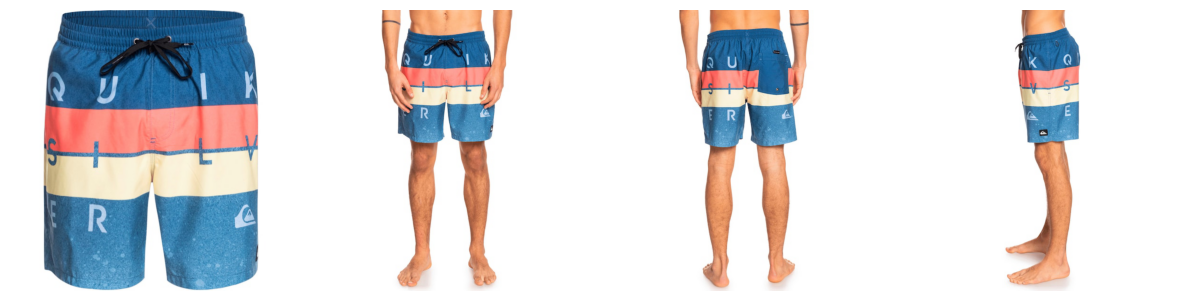

In [ ]:
print('Zalando')
plot_images(product)

In [ ]:
product = get_offer(offers_training_df, matches_training_df.iloc[9209], 'aboutyou')
product

offer_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

AboutYou


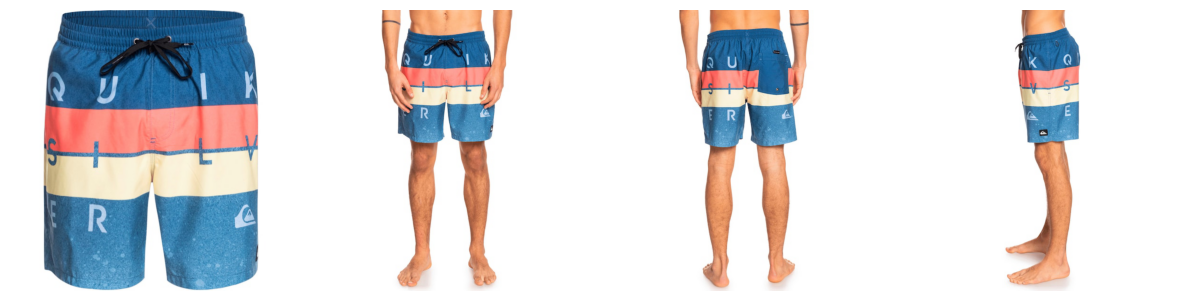

In [ ]:
print('AboutYou')
plot_images(product)

## Segregating Zalando and AboutYOU Files

### Obtaining a CSV for Zalando products which are in matches_training.parquet dataset

In [ ]:
Zalando_matches_training=[]
for i in range(len(matches_training_df['zalando'])):
  matches = list(get_offer(offers_training_df, matches_training_df.iloc[i], 'zalando'))
  Zalando_matches_training+=[matches]

In [ ]:
zalando_matches_df = pd.DataFrame(list(Zalando_matches_training), columns = ['Offer_ID','Shop','Lang','Brand','Color','Title','Description','Price','URLs','Image_URLs']) 

In [ ]:
zalando_matches_df.shape

(15170, 10)

In [ ]:
zalando_matches_df.head(5)

,Offer_ID,Shop,Lang,Brand,Color,Title,Description,Price,URLs,Image_URLs
0,b33f55d6-0149-4063-8b63-3eeae63562a2,zalando,de,Swarovski,silberfarben,CREATIVITY Halskette,main_supplier_code K85009 $ name_suffix silver $ stone_type Swarovski®-Kristall $ color_code.primary silberfarben $ finish Rhodiniert | Poliert $ season_code Ganzjähriger Basisartikel $ visibility_high ja $ season_code.first Herbst-Winter 2020 $ fastening Karabiner $ name CREATIVITY:PENDANT CIR CRY/ROS $ tag Halskette $ silhouette jewellery $ assortment_type Katalog $ brand_code 4SW $ name_prefix CREATIVITY $ product_group accessoires $ commodity_group 5-1-L,59.867273,https://www.zalando.de/lookup/article/4SW51L016-D11,"[https://img01.ztat.net/article/46ee8503931f4958b2d4a4f8caf8d468/2eaa610d6c254eac81f09a32c4dad26a.jpg?imwidth=762, https://img01.ztat.net/article/cbcb0549530c4285ac49842f99b2b2ea/96e84b96e87f4b42b8e4878261a07346.jpg?imwidth=762, https://img01.ztat.net/article/6a212bab33ea4d9697d78ca2db9fb81e/fda9f63ed4b646bbaff955f7ac563c9f.jpg?imwidth=762, https://img01.ztat.net/article/4b335d71a4c040c58c7269d979f29cf5/68084cee595e4287ac31987f5cc0f0c7.jpg?imwidth=762]"
1,f04bef4a-f771-4749-914c-1b22718523b8,zalando,de,Swarovski,roségoldfarben,LIFELONG BANGLE Armband,main_supplier_code K85009 $ name_suffix rosegold-coloured $ stone_type Swarovski®-Kristall $ color_code.primary roségoldfarben $ jewelry_closure Karabiner $ finish Rosévergoldet | Poliert $ season_code Herbst-Winter 2021 $ season_code.first Frühjahr - Sommer 2018 $ material_jewelry Metall $ name LIFELONG:BANGLE CRY/ROS $ tag Armband $ silhouette jewellery $ assortment_type Katalog $ brand_code 4SW $ name_prefix LIFELONG BANGLE $ product_group accessoires $ commodity_group 5-1-L-03,99.685455,https://www.zalando.de/lookup/article/4SW51L01P-F11,"[https://img01.ztat.net/article/0481d0dea44c3ba9887d308686e68e7d/300cda26029d4c1cb16ceeaf3d6110f7.jpg?imwidth=762, https://img01.ztat.net/article/d619383b921f3637aa7f2489c856ecae/a966bc928733415bb67dfb1d5a7286ed.jpg?imwidth=762, https://img01.ztat.net/article/5513a49547733488abf3b7c6e50a1453/cf1b3ee5da6d4a2584e0c93dbbc4b476.jpg?imwidth=762, https://img01.ztat.net/article/88af10b57f413008a330f3cf4b324ce2/993e301efc574010bc316a5a0fd0fc73.jpg?imwidth=762, https://img01.ztat.net/article/27cb6bede46f3a7c9e82dc17d54f20dc/192e4ca331114268931a38ea5fa793fb.jpg?imwidth=762]"
2,396c292a-cda8-4477-ac67-86701fc8ab95,zalando,de,Swarovski,silberfarben,ETERNAL FLOWER BANGLE FLY Armband,main_supplier_code K85009 $ name_suffix fancy morganite $ stone_type Swarovski®-Kristall $ color_code.primary silberfarben $ finish Poliert $ season_code Herbst-Winter 2021 $ season_code.first Frühjahr - Sommer 2020 $ fastening Karabiner $ name ETERNAL FLOWER:BANGLE FLY CZMO/ROS M $ tag Armband $ silhouette jewellery $ brand_code 4SW $ name_prefix ETERNAL FLOWER BANGLE FLY $ product_group accessoires $ commodity_group 5-1-L-03,99.867273,https://www.zalando.de/lookup/article/4SW51L0GC-D11,"[https://img01.ztat.net/article/df79c32ea57a375c94497a9d4531936c/6e010ded7c0a4076972dba453bb1e857.jpg?imwidth=762, https://img01.ztat.net/article/512f7cd6c08a357e816c4ef0c3d862bc/5496e8fe75f7455eaabad67857698e25.jpg?imwidth=762, https://img01.ztat.net/article/f3ac1fdb5bf83308979205508b7f344e/d68c13a571804b78b3e86741e9269961.jpg?imwidth=762, https://img01.ztat.net/article/fae7b1dc6d383b088c8e4807fb0525bb/e0bf87b775974544865201386b4ff1be.jpg?imwidth=762, https://img01.ztat.net/article/6726453f86943229ae6026884909700d/6341efa72abd4826bcd60f64e1712b71.jpg?imwidth=762, https://img01.ztat.net/article/aadb20d56bc24d25950bcb6011887cc9/5947fe36541d4744889fa967f587ca2b.jpg?imwidth=762]"
3,e72b5d05-fd06-46e9-a183-5e2e26ed18bb,zalando,de,Swarovski,silberfarben,ANGELIC BRACELET Armband,main_supplier_code K85009 $ name_suffix crystal $ stone_type Swarovski®-Kristall $ color_code.primary silberfarben $ finish Rhodiniert | Poliert $ season_code Ganzjähriger Basisartikel $ season_code.first Frühjahr - Sommer 2020 $ fastening Gelen

In [ ]:
zalando_matches_df.to_csv('/content/drive/MyDrive/ML_Assignment/zalando_matches_training.csv')

### Obtaining a CSV for AboutYou products which are in matches_training.parquet dataset

In [ ]:
AboutYou_matches_training=[]
for i in range(len(matches_training_df['aboutyou'])):
  AY_matches = list(get_offer(offers_training_df, matches_training_df.iloc[i], 'aboutyou'))
  AboutYou_matches_training+=[AY_matches]

In [ ]:
AboutYou_matches_df = pd.DataFrame(list(AboutYou_matches_training), columns = ['Offer_ID','Shop','Lang','Brand','Color','Title','Description','Price','URLs','Image_URLs']) 

In [ ]:
AboutYou_matches_df.head(10)

,Offer_ID,Shop,Lang,Brand,Color,Title,Description,Price,URLs,Image_URLs
0,ad5ceb87-0254-4171-b650-1d4d09f48efc,aboutyou,de,Swarovski,silber | weiß | Silber,Kette,"{""Gr\u00f6\u00dfe"": [""Unisex - Onesize (Onesize, Onesize, Einheitsgr\u00f6\u00dfe, 1)""], ""Zielgruppe"": [""Female""], ""Ketten-Stil"": [""Feine Kette""], ""Marke"": [""Swarovski""], ""Anh\u00e4nger"": [""Mit Anh\u00e4nger""], ""Schmuckart"": [""Modeschmuck""], ""Ausrichtung Marke"": [""Premium""], ""Suchfarbe"": [""Silber""], ""Gr\u00f6\u00dfenlauf"": [""Unisex - Onesize (Onesize, Onesize, Einheitsgr\u00f6\u00dfe, 1)""], ""Detailfarbe"": [""silber"", ""wei\u00df""], ""Business"": [""Freizeit""], ""Geschlecht"": [""Frauen""], ""Produktart"": [""Kette""], ""Quick Filter Style Group"": [""Premium""], ""Schmuckvertrieb"": [""Modeschmuck""], ""Neu"": [""new_aode""], ""Display Colors"": [""silber""], ""Brand logo"": [""Swarovski""], ""Premium"": true, ""Name"": [""Kette""], ""Description"": [""Collier Metall mit Swarovski-Kristallen L\u00e4nge ca. 38 cm, Breite ca. 1,5 cm, Anh\u00e4ngerl\u00e4nge ca. 1,5 cm, Anh\u00e4ngerbreite ca. 2 cm""], ""Produkt Beschreibung"": ""Collier Metall mit Swarovski-Kristallen L\u00e4nge ca. 38 cm, Breite ca. 1,5 cm, Anh\u00e4ngerl\u00e4nge ca. 1,5 cm, Anh\u00e4ngerbreite ca. 2 cm"", ""Bulletpoints"": ""Material: Metall Farbe: silber Ma\u00dfangaben: Anh\u00e4ngerl\u00e4nge ca. 1,8 cm, Anh\u00e4ngerbreite ca. 1,4 cm Wir liefern Ihr Schmuckst\u00fcck in einer eleganten Produktverpackung - ideal f\u00fcr Geschenke Profitieren Sie vom CHRIST Uhren- & Schmuckservice sowie der Fachexpertise aus mehr als 200 Filialen in Deutschland"", ""Materialzusammensetzung"": ""Material Metall Glas""}",65.0,https://www.aboutyou.de/p/swarovski/kette-4364831,"[https://cdn.aboutstatic.com/file/9e47383c6bd49a547330b889fc1677a1?width=600&height=800&quality=0.90, https://cdn.aboutstatic.com/file/4de645e830b8337a5a2520cfc5e4bbce?width=600&height=800&quality=0.90, https://cdn.aboutstatic.com/file/1f13a6dd8fcba1f600241f5870f3f0f3?width=600&height=800&quality=0.90]"
1,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,aboutyou,de,Swarovski,rosegold | Gold,Armreif,"{""Gr\u00f6\u00dfe"": [""Unisex - Intern. Accessoires""], ""Zielgruppe"": [""Female""], ""Marke"": [""Swarovski""], ""Schmuckart"": [""Modeschmuck""], ""Ausrichtung Marke"": [""Premium""], ""Suchfarbe"": [""Gold""], ""Gr\u00f6\u00dfenlauf"": [""Unisex - Intern. Accessoires""], ""Detailfarbe"": [""rosegold""], ""Business"": [""Freizeit""], ""Geschlecht"": [""Frauen""], ""Produktart"": [""Armband""], ""Quick Filter Style Group"": [""Premium""], ""Schmuckvertrieb"": [""Modeschmuck""], ""Display Colors"": [""rosegold""], ""Brand logo"": [""Swarovski""], ""Premium"": true, ""Name"": [""Armreif""], ""Description"": [""Armreif Metall mit Swarovski Kristalle Durchmesser ca. 5 cm""], ""Produkt Beschreibung"": ""Armreif Metall mit Swarovski Kristalle Durchmesser ca. 5 cm"", ""Bulletpoints"": ""Material: Metall Farbe: ros\u00e8 Ma\u00dfangaben: Durchmesser ca. 5 cm Wir liefern Ihr Schmuckst\u00fcck in einer eleganten Produktverpackung - ideal f\u00fcr Geschenke Profitieren Sie vom CHRIST Uhren- & Schmuckservice sowie der Fachexpertise aus mehr als 200 Filialen in Deutschland"", ""Materialzusammensetzung"": ""Material Metall Glas""}",115.0,https://www.aboutyou.de/p/swarovski/armreif-4335972,[https://cdn.aboutstatic.com/file/4068d48b30b9d86b117aa1442ccc3928?width=600&height=800&quality=0.90]
2,7d19213c-b3ea-406a-ac8e-8299823c7bb4,aboutyou,de,Swarovski,rosegold | silber | Silber,Armreif 'Eternal Flower',"{""Gr\u00f6\u00dfe"": [""Unisex - Schmuck intern.""], ""Marke"": [""Swarovski""], ""Schmuckart"": [""Modeschmuck""], ""Oberfl\u00e4che"": [""Rhodiniert""], ""Ausrichtung Marke"": [""Premium""], ""Suchfarbe"": [""Silber""], ""Gr\u00f6\u00dfenlauf"": [""Unisex - Schmuck intern.""], ""Detailfarbe"": [""rosegold"", ""silber""], ""Ordersaison"": [""FS 20""], ""Business"": [""Freizeit""], ""Geschlecht"": [""Frauen""], ""Produktart"": [""Ar

In [ ]:
AboutYou_matches_df.shape

(15170, 10)

In [ ]:
AboutYou_matches_df.to_csv('/content/drive/MyDrive/ML_Assignment/aboutyou_matches_training.csv')

## Preprocessing the two csv files for Zalando and AboutYOU

In [ ]:
import json
df_zal = pd.read_csv("/content/drive/MyDrive/ML_Assignment/zalando_matches_training.csv")
df_about = pd.read_csv("/content/drive/MyDrive/ML_Assignment/aboutyou_matches_training.csv")

In [ ]:
print(f"Columns of Zalando are {df_zal.columns}")
print(f"Columns of About YOU are {df_about.columns}")

Columns of Zalando are Index(['Unnamed: 0', 'Offer_ID', 'Shop', 'Lang', 'Brand', 'Color', 'Title',
       'Description', 'Price', 'URLs', 'Image_URLs'],
      dtype='object')
Columns of About YOU are Index(['Unnamed: 0', 'Offer_ID', 'Shop', 'Lang', 'Brand', 'Color', 'Title',
       'Description', 'Price', 'URLs', 'Image_URLs'],
      dtype='object')


### Preparing dataset for Binary Classifier to get whether the two products are duplicate or not

In [ ]:
# Creating a dataframe to store Title and Colour columns of Zalando and AboutYou
df2 = pd.DataFrame()
df2['title_about_you'] = df_about['Title']
df2['title_zalando'] = df_zal['Title']
df2['color_about_you'] = df_about['Color']
df2['color_zalando'] = df_zal['Color']
df2['price_about_you'] = df_about['Price']
df2['price_zalando'] = df_zal['Price']
df2['is_duplicate'] = [1]*len(df2)

In [ ]:
df2

,title_about_you,title_zalando,color_about_you,color_zalando,price_about_you,price_zalando,is_duplicate
0,Kette,CREATIVITY Halskette,silber | weiß | Silber,silberfarben,65.00,59.867273,1
1,Armreif,LIFELONG BANGLE Armband,rosegold | Gold,roségoldfarben,115.00,99.685455,1
2,Armreif 'Eternal Flower',ETERNAL FLOWER BANGLE FLY Armband,rosegold | silber | Silber,silberfarben,99.00,99.867273,1
3,Armband,ANGELIC BRACELET Armband,silber | Silber,silberfarben,125.00,129.867273,1
4,Armband,CONSTELLA BANGLE Armband,weiß | rosegold | Gold,weiß,105.00,89.867273,1
...,...,...,...,...,...,...,...
15165,GUESS Quarzuhr,Uhr,silber | Silber,silberfarben,159.00,159.867273,1
15166,Uhr,Uhr,gold | silber | Gold,goldfarben,179.00,179.867273,1
15167,Uhr,Chronograph,rosegold | Gold,roségoldfarben,239.00,239.867273,1
15168,Uhr,Uhr,gold | rosegold | Gold,roségoldfarben,169.00,169.867273,1


In [ ]:
df2.isnull().sum()

title_about_you    0
title_zalando      1
color_about_you    2
color_zalando      0
price_about_you    0
price_zalando      2
is_duplicate       0
dtype: int64

In [ ]:
df2 = df2.dropna()

In [ ]:
df2.columns

Index(['title_about_you', 'title_zalando', 'color_about_you', 'color_zalando',
       'price_about_you', 'price_zalando', 'is_duplicate'],
      dtype='object')

### Shuffling the data of AboutYOU in the dataframe to balance the dataset for no matches to prepare the training data for the classifier

In [ ]:
df_shuffle = df2[['title_about_you', 'color_about_you','price_about_you']]

In [ ]:
df_shuffle

,title_about_you,color_about_you,price_about_you
0,Kette,silber | weiß | Silber,65.00
1,Armreif,rosegold | Gold,115.00
2,Armreif 'Eternal Flower',rosegold | silber | Silber,99.00
3,Armband,silber | Silber,125.00
4,Armband,weiß | rosegold | Gold,105.00
...,...,...,...
15165,GUESS Quarzuhr,silber | Silber,159.00
15166,Uhr,gold | silber | Gold,179.00
15167,Uhr,rosegold | Gold,239.00
15168,Uhr,gold | rosegold | Gold,169.00


In [ ]:
df_shuffle = df_shuffle.sample(frac = 1).reset_index(drop=True)

In [ ]:
df_shuffle = pd.concat([df_shuffle, df2[['title_zalando','color_zalando','price_zalando']]], axis=1) #concat by columns

In [ ]:
df_shuffle.tail(50)

,title_about_you,color_about_you,price_about_you,title_zalando,color_zalando,price_zalando
15120,T-Shirt,weiß | gold | schwarz | nude | hellgelb | Weiß,44.90,Sweatshirt,schwarz,39.958182
15121,Jeans 'Dacy',hellblau | Blau,139.00,NILLE Jeans Slim Fit,blue denim,89.049091
15122,Uhr,silber | transparent | Silber,199.00,EMILY Jeans Slim Fit,blue denim,39.958182
15123,Pullover 'Lulu',pastellpink | Pink,49.99,NILLE Jeans Slim Fit,black denim,89.958182
15124,Übergangsjacke,oliv | navy | schwarz | weiß | Grün,65.99,GEMMA Jeans Straight Leg,blue denim,88.503636
15125,Fahrradhose,schwarz | Schwarz,203.90,AMY Jeans Skinny Fit,dark-blue denim,79.799091
15126,T-Shirt 'Prado',dunkelgrau | schwarz | rot | gelb | Grau,24.90,AMY LONG Jeans Skinny Fit,grey denim,39.594545
15127,Print Oberteil,apricot | blau | Beige,29.99,AMY LONG Jeans Skinny Fit,blue denim,40.230909
15128,Hausschuh,wollweiß | Weiß,39.90,AMY LONG Jeans Skinny Fit,schwarz,39.594545
15129,T-Shirt,weiß | schwarz | braun | hellbeige | Weiß,59.90,SANNA Jeans Skinny Fit,blue denim,49.958182


In [ ]:
df_shuffle= df_shuffle.dropna()

In [ ]:
df_shuffle['is_duplicate'] = [0]*len(df_shuffle)

### Concatenating the class 0 and class 1 data to form training file for the model

In [ ]:
df_train = pd.concat([df_shuffle, df2], axis=0)

In [ ]:
df_train.to_csv('/content/drive/MyDrive/ML_Assignment/train_data.csv',index=False)

## Training the Model

### Preprocessing Steps for training file 'train.csv'

In [ ]:
# Loading "stopwords" and "SnowballStemmer" based on German language to remove morphological affixes from German words
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Try to run on TPU
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
#Specifying directories to save the trained model and checkpoints
CURR_PATH = '/content/drive/MyDrive/ML_Assignment/'
PATH_DATA = CURR_PATH
PATH_MODELS = PATH_DATA + "models/"
PATH_CHECKPOINTS = PATH_MODELS + "checkpoints/"

In [ ]:
PATH_DATA

'/content/drive/MyDrive/ML_Assignment/'

### Configuration Parameters for the model

In [ ]:
# Text Vectors
MAX_FEATURES = 30000
EMBED_DIM = 300
MAXLEN = 400

# Convolution
KERNEL_SIZE = 5
FILTERS = 64
POOL_SIZE = 4

# LSTM
LSTM_OUTPUT_SIZE = 100

# Training
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
EPOCHS = 10

### Function to perform cleaning of textual data

In [ ]:
#Function to perform cleaning of textual data
def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    text = text.lower()
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

In [ ]:
# Loading training dataset for model
data = pd.read_csv(PATH_DATA + "/train_data.csv")

In [ ]:
data['combined_data'] = [data['title_about_you'][i]+' '+data['color_about_you'][i]+' '+data['title_zalando'][i]+' '+data['color_zalando'][i] for i in range(len(data))]
data["comment_clean"] = data["combined_data"].map(lambda x: clean_text(x, for_embedding=True) if isinstance(x, str) else x)

In [ ]:
data["comment_clean"]

0                                  rucksack blane schwarz schwarz creativity halskette silberfarben
1                                          kleid rostrot rot lifelong bangle armband roségoldfarben
2        kleid schwarz creme weiß dunkelgrün schwarz eternal flower bangle fly armband silberfarben
3                                           sneaker weiß weiß angelic bracelet armband silberfarben
4                                       jacke supreme schwarz schwarz constella bangle armband weiß
                                                    ...                                            
30320                                                 guess quarzuhr silber silber uhr silberfarben
30321                                                           uhr gold silber gold uhr goldfarben
30322                                                  uhr rosegold gold chronograph roségoldfarben
30323                                                     uhr gold rosegold gold uhr roségoldfarben


### Splitting 'train.csv' into train and test set and sampling data for cross validation

In [ ]:
# Sample data for cross validation
train, test = train_test_split(data, random_state=1, test_size=0.25, shuffle=True)
X_train = np.array(train["comment_clean"])
Y_train = np.array(train["is_duplicate"]).reshape((-1, 1))
X_test = np.array(test["comment_clean"])
Y_test = np.array(test["is_duplicate"]).reshape((-1, 1))
print(X_train.shape)
print(X_test.shape)

(22743,)
(7582,)


### Vector Representation of the data

In [ ]:
%%time
# create numerical vector representation of comments
# comment to list of indices representing words in dict
tokenizer = Tokenizer(lower=True, split=" ", num_words=MAX_FEATURES)
tokenizer.fit_on_texts(X_train)
X_train_vec = tokenizer.texts_to_sequences(X_train)
X_test_vec = tokenizer.texts_to_sequences(X_test)
MAXLEN = max([len(x) for x in X_train_vec])
print(f"Max vector length: {MAXLEN}")

Max vector length: 21
CPU times: user 900 ms, sys: 18.1 ms, total: 918 ms
Wall time: 914 ms


### Padding the created sequences with zeroes to create vectors of same length

In [ ]:
# pad with zeros for same vector length
X_train_vec = sequence.pad_sequences(X_train_vec, maxlen=MAXLEN, padding="post")
X_test_vec = sequence.pad_sequences(X_test_vec, maxlen=MAXLEN, padding="post")

In [ ]:
tmp = train[0:1].copy()
tmp["vector"] = list(X_train_vec[0:1])
tmp

,title_about_you,color_about_you,price_about_you,title_zalando,color_zalando,price_zalando,is_duplicate,combined_data,comment_clean,vector
7626,Snowboots 'LARYA',schwarz | Schwarz,209.0,PCMOLLY DRESS Strickkleid,schwarz,29.990909,0,Snowboots 'LARYA' schwarz | Schwarz PCMOLLY DRESS Strickkleid schwarz,snowboots larya schwarz schwarz pcmolly dress strickkleid schwarz,"[2527, 2159, 1, 1, 1684, 12, 70, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


### Defining the Model Architecture

In [ ]:
# Define NN architecture
with strategy.scope():
    model = Sequential()
    model.add(
        Embedding(input_dim=MAX_FEATURES, output_dim=EMBED_DIM, input_length=MAXLEN)
    )
    model.add(Dropout(0.3))
    model.add(
        Conv1D(FILTERS, KERNEL_SIZE, padding="valid", activation="relu", strides=1)
    )
    model.add(MaxPooling1D(pool_size=POOL_SIZE))
    model.add(LSTM(LSTM_OUTPUT_SIZE))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.RMSprop(),
        metrics=["accuracy"],
    )

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 300)           9000000   
                                                                 
 dropout (Dropout)           (None, 21, 300)           0         
                                                                 
 conv1d (Conv1D)             (None, 17, 64)            96064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 64)            0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                        

### Early Stop Training Mechanism and saving checkpoints

In [ ]:
# Stop training when validation acc starts dropping
# Save checkpoint of model each period
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", verbose=1, patience=2),
    ModelCheckpoint(
        PATH_CHECKPOINTS + now + "_Model_{epoch:02d}_{val_loss:.4f}.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1,
    ),
]

### Training the Model with model.fit

In [ ]:
%%time
# Fit the model
steps_per_epoch = int(np.floor((len(X_train_vec) / BATCH_SIZE)))
print(
    f"Model Params.\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
)

hist = model.fit(
    X_train_vec,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    validation_data=(X_test_vec, Y_test),
)

Model Params.
batch_size: 32
Epochs: 10
Step p. Epoch: 710

Epoch 1/10
707/710 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.5508
Epoch 1: val_loss improved from inf to 0.58966, saving model to /content/drive/MyDrive/ML_Assignment/models/checkpoints/2022-03-29_1133_Model_01_0.5897.h5
710/710 [==============================] - 18s 7ms/step - loss: 0.6684 - accuracy: 0.5511 - val_loss: 0.5897 - val_accuracy: 0.6418
Epoch 2/10
700/710 [============================>.] - ETA: 0s - loss: 0.5286 - accuracy: 0.7329
Epoch 2: val_loss improved from 0.58966 to 0.49163, saving model to /content/drive/MyDrive/ML_Assignment/models/checkpoints/2022-03-29_1133_Model_02_0.4916.h5
710/710 [==============================] - 4s 6ms/step - loss: 0.5284 - accuracy: 0.7329 - val_loss: 0.4916 - val_accuracy: 0.7702
Epoch 3/10
710/710 [==============================] - ETA: 0s - loss: 0.4577 - accuracy: 0.7916
Epoch 3: val_loss improved from 0.49163 to 0.48175, saving model to /conten

In [ ]:
len(X_train_vec[0])

21

### Predicting matches in the test set

In [ ]:
# Predict on test data
pred = model.predict(X_test_vec)
pred_class = (pred > 0.5).astype(int)
pred_len = X_test_vec.shape[0]

In [ ]:
pred

array([[0.9215905 ],
       [0.21640131],
       [0.00112061],
       ...,
       [0.9552883 ],
       [0.1088035 ],
       [0.00268086]], dtype=float32)

### Calculating F1 Score

In [ ]:
report = metrics.classification_report(Y_test, pred_class[0:pred_len])
print(report)

              precision    recall  f1-score   support

           0       0.87      0.78      0.82      3878
           1       0.79      0.88      0.83      3704

    accuracy                           0.83      7582
   macro avg       0.83      0.83      0.83      7582
weighted avg       0.83      0.83      0.83      7582



In [ ]:
len(Y_test)

7582

### Calculating Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, pred_class)

array([[3024,  854],
       [ 445, 3259]])

### Saving the Model into Google Drive

In [ ]:
import pickle
with open('/content/drive/MyDrive/ML_Assignment/models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model_architecture = model.to_json()
with open("/content/drive/MyDrive/ML_Assignment/models/model_arch.json", "w") as json_file:
    json_file.write(model_architecture)

In [ ]:
model.save_weights("/content/drive/MyDrive/ML_Assignment/models/model_weights.h5")
print("Saved model to disk")

Saved model to disk


## Predicting Matches in Zalando and AboutYOU Products from Unseen Dataset 'offers_test.csv'

### GPU config and utilization

In [ ]:
MAX_SEQUENCE_LENGTH = 21

K.clear_session()
tokenizer = None

config = tf.compat.v1.ConfigProto(
	device_count={'GPU': 1},
	intra_op_parallelism_threads=1,
	allow_soft_placement=True
)

config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6

session = tf.compat.v1.Session(config=config)

tf.compat.v1.keras.backend.set_session(session)

### Loading the earlier saved model

In [ ]:
with open('/content/drive/MyDrive/ML_Assignment/models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

with open('/content/drive/MyDrive/ML_Assignment/models/model_arch.json', 'rb') as json_file:
    loaded_model_json = json_file.read()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/drive/MyDrive/ML_Assignment/models/model_weights.h5")

model = SentenceTransformer("Sahajtomar/German-semantic")

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/328 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/240k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

## Generating prediction for possible matching products between Zalando and AboutYOU on 'offers_test.csv' and Ranking the products based on semantic similarity.

In [ ]:
# def execute():
df = pd.read_csv('/content/drive/MyDrive/ML_Assignment/offers_test.csv')
df_about = df.loc[df['shop'] == 'aboutyou']
df_zal = df.loc[df['shop'] == 'zalando']
print(len(df_about))
print(len(df_zal))
match_offer_id = []
status = []
for i in range(len(df_zal)):
  seq_data = []
  df_about_brand_filter = df_about.loc[df_about['brand'] == df_zal['brand'].iloc[i]]
  if len(df_about_brand_filter)!=0:
    seq_data = [str(df_about_brand_filter['title'].iloc[j])+' '+str(df_about_brand_filter['color'].iloc[j])+' '+str(df_zal['title'].iloc[i])+' '+str(df_zal['color'].iloc[i]) for j in range(len(df_about_brand_filter))]
    clean_seq_data = list(map(lambda x: clean_text(x, for_embedding=True) if isinstance(x, str) else x,seq_data))
    seq = tokenizer.texts_to_sequences(clean_seq_data)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = loaded_model.predict(padded) #Retrieving normalized value between 0 to 1
    pred_class = (pred > 0.5).astype(int) # Values which are greater than 0.5 are considered as 1
    possible_matches_pos = list(np.where(pred_class.flatten()==1)[0])
    if len(possible_matches_pos)!=0:
      df_possible_match = df_about_brand_filter.iloc[possible_matches_pos]
      about_you_text = [clean_text(' '.join([str(df_possible_match['title'].iloc[k]),str(df_possible_match['color'].iloc[k])]),for_embedding=True) for k in range(len(df_possible_match))]
      about_you_embedding = model.encode(about_you_text,convert_to_tensor=True)
      zal_text = [clean_text(str(df_zal['title'].iloc[i])+' '+str(df_zal['color'].iloc[i]),for_embedding=True)]
      zalando_embedding = model.encode(zal_text,convert_to_tensor=True)
      cosine_scores = util.pytorch_cos_sim(zalando_embedding, about_you_embedding)
      max_score = cosine_scores.max()
      match_position = np.where(cosine_scores[0].cpu()==max_score.item())[0][0]
      about_you_offer_id = df_possible_match.iloc[match_position].get('offer_id')
      
      match_offer_id+=[about_you_offer_id]
      status+=['Possible Match Found']
    else:
      match_offer_id+=['Not Found']
      status+=['No possible match found by the Classifier']
  else:
    match_offer_id+=['Not Found']
    status+=['Matching Brand not found']
  print(i)

Streaming output truncated to the last 5000 lines.
31527
31528
31529
31530
31531
31532
31533
31534
31535
31536
31537
31538
31539
31540
31541
31542
31543
31544
31545
31546
31547
31548
31549
31550
31551
31552
31553
31554
31555
31556
31557
31558
31559
31560
31561
31562
31563
31564
31565
31566
31567
31568
31569
31570
31571
31572
31573
31574
31575
31576
31577
31578
31579
31580
31581
31582
31583
31584
31585
31586
31587
31588
31589
31590
31591
31592
31593
31594
31595
31596
31597
31598
31599
31600
31601
31602
31603
31604
31605
31606
31607
31608
31609
31610
31611
31612
31613
31614
31615
31616
31617
31618
31619
31620
31621
31622
31623
31624
31625
31626
31627
31628
31629
31630
31631
31632
31633
31634
31635
31636
31637
31638
31639
31640
31641
31642
31643
31644
31645
31646
31647
31648
31649
31650
31651
31652
31653
31654
31655
31656
31657
31658
31659
31660
31661
31662
31663
31664
31665
31666
31667
31668
31669
31670
31671
31672
31673
31674
31675
31676
31677
31678
31679
31680
31681
31682
31683
31684
3

### Retrieving the offer IDs of Zalando and AboutYOU which are possible matches

In [ ]:
df_zal ['About You Offer ID']=match_offer_id
df_zal['Comments']=status

df_zal.to_csv('/content/drive/MyDrive/ML_Assignment/Zalando_Product_Match_Report.csv',index=False)
df_about.to_csv('/content/drive/MyDrive/ML_Assignment/About_You_Test_Product.csv',index=False)


zalando_id= []
ay_id= []
for i in range(len(df_zal['Comments'])):
  if df_zal['Comments'].iloc[i] =='Possible Match Found':
    zalando_id.append(df_zal['offer_id'].iloc[i])
    ay_id.append(df_zal['About You Offer ID'].iloc[i])

df_predicted_match = pd.DataFrame(list(zip(zalando_id, ay_id)), columns =['zalando', 'aboutyou']) 

df_predicted_match.to_csv('/content/drive/MyDrive/ML_Assignment/matches_test_predicted.csv',index=False)
df_predicted_match.to_parquet('/content/drive/MyDrive/ML_Assignment/matches_test_predicted.parquet')

In [ ]:
df_predicted_match.tail(10)

,zalando,aboutyou
9986,e62571ea-cfff-4306-acf6-581ea510d7eb,a24c0ecf-e9ce-480d-9533-a8fe32dc99d0
9987,2cd98aac-9043-4b66-8072-0cd33d0360db,0688b792-919b-4efd-b418-296b330e118b
9988,7c5bd6b8-f50a-4db7-8c3f-310eb1c87eb8,dcf660d8-4a7b-4197-9d19-2d2f1c63f4c1
9989,8ec1caea-c98f-45e5-a710-2481f232210a,90dd4639-2787-4f45-9989-2a0074ff1150
9990,4075990a-40b7-4cf1-9353-7e7a55c07c02,37377458-77ee-49b4-b1b2-a113f2baae70
9991,9ba77b22-6623-4df9-8c78-163806aebc0b,a9a58d84-15c7-4624-99d9-a91855b59d54
9992,331fc436-c8ef-4096-92b5-f9ae6481a231,2b5c2ef0-7612-4b37-b0cb-0edffb38508e
9993,fdd30a75-9f1a-4c71-83dc-4374a08c0d1e,086cf06e-e92b-4be5-86d4-f6ee97756fdf
9994,6a846d7d-0207-4b8d-8368-7f24f9a6d0f5,61cd8272-93b0-432a-bf0f-1942a0f1f29b
9995,d6a7c115-691f-466e-95d1-0091d41622d4,a6862706-f5b6-4f56-8ead-3540884fb0a5
